In [1]:
import pandas as pd
import cptac
import statistics as st
import cptac.utils as ut
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import transform_pval 
from scipy import stats
import scipy

In [2]:
ccrcc = cptac.Ccrcc()
en = cptac.Endometrial()
luad = cptac.Luad()
hnscc  = cptac.Hnscc()
lscc = cptac.Lscc()

cptac warning: The LSCC data is currently strictly reserved for CPTAC investigators. Otherwise, you are not authorized to access these data. Additionally, even after these data become publicly available, they will be subject to a publication embargo (see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details). (<ipython-input-2-5c25f03e6d4a>, line 5)


In [3]:
cancer_dict = {ccrcc:"ccrcc",en:"endometrial",luad:"luad", hnscc:"hnscc",lscc:"lscc"}
cancer_list = [ccrcc,en,luad,hnscc,lscc]

In [4]:
mutated_gene = 'TP53'

In [5]:
def get_omics_df(cancer):
    transcriptomics_df = cancer.get_transcriptomics(tissue_type='tumor')
    proteomics_df = cancer.get_proteomics(tissue_type='tumor')
    if isinstance(proteomics_df.columns, pd.MultiIndex):
        proteomics_df = proteomics_df.droplevel('Database_ID', axis = 1)
    if isinstance(transcriptomics_df.columns, pd.MultiIndex):
        transcriptomics_df = transcriptomics_df.droplevel('Database_ID', axis = 1)
    proteomics_df['patient_ID'] = proteomics_df.index
    transcriptomics_df['patient_ID'] = transcriptomics_df.index
    transcriptomics_df = transcriptomics_df.melt(id_vars='patient_ID', var_name = 'gene', value_name='transcriptomics')
    proteomics_df = proteomics_df.melt(id_vars='patient_ID', var_name = 'gene', value_name='proteomics')
    mutation_df = cancer.get_somatic_mutation()
    mutation_df = mutation_df[mutation_df.Gene == mutated_gene]
    omics_df = pd.merge(transcriptomics_df, proteomics_df, how = 'inner')
    omics_df['mutation_status'] = omics_df.patient_ID.isin(mutation_df.index)
    omics_df = omics_df.dropna()
    return omics_df

In [6]:
def get_corr_df(omics_df):
    mut_corrs = []
    mut_p_vals = []
    non_mut_corrs = []
    non_mut_p_vals = []
    corr_diffs = []
    corr_diff_pvals = []
    genes = []
    for gene in pd.unique(omics_df.gene):
        df = omics_df[omics_df.gene == gene]
        mut_df = df[df.mutation_status == True]
        non_mut_df = df[df.mutation_status == False]
        if len(mut_df) < 4 or len(non_mut_df) < 4:
            continue
        mut_r, mut_p = stats.pearsonr(mut_df.transcriptomics, mut_df.proteomics)
        non_mut_r, non_mut_p = stats.pearsonr(non_mut_df.transcriptomics, non_mut_df.proteomics)
        mut_corrs.append(mut_r)
        mut_p_vals.append(mut_p)
        non_mut_corrs.append(non_mut_r)
        non_mut_p_vals.append(non_mut_p)
        corr_diff = mut_r - non_mut_r
        corr_diffs.append(corr_diff)
        diff_p_val = transform_pval.compare_correlations(mut_r, non_mut_r, len(mut_df), len(non_mut_df))
        corr_diff_pvals.append(diff_p_val)
        genes.append(gene)
    correlation_df = pd.DataFrame({'gene': genes, 'mutated_correlation': mut_corrs, 'non_mutated_correlation': non_mut_corrs,
                                   'non_mutated_p_vals': non_mut_p_vals, 'mutated_p_vals': mut_p_vals,
                                   'delta_correlation': corr_diffs, 'delta_correlation_pval': corr_diff_pvals})
    return correlation_df

In [7]:
omics_dfs = []
for cancer in cancer_list:
    print(cancer_dict[cancer])
    df = get_omics_df(cancer)
    df['cancer'] = [cancer_dict[cancer]] * len(df)
    omics_dfs.append(df)
omics_df = pd.concat(omics_dfs)

ccrcc
endometrial
luad
hnscc
lscc


In [8]:
correlation_dfs = []
for df in omics_dfs:
    cancer = list(pd.unique(df['cancer']))
    print(cancer)
    corr_df = get_corr_df(df)
    corr_df['cancer'] =  cancer * len(corr_df)
    correlation_dfs.append(corr_df)
correlation_df = pd.concat(correlation_dfs)
correlation_df.to_csv('TP53_trans_effects.csv')

['ccrcc']


C:\Users\nanel\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
C:\Users\nanel\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


['endometrial']
['luad']
['hnscc']
['lscc']


In [12]:
sig_correlation_changes = []
for cancer in pd.unique(correlation_df.cancer):
    df = correlation_df[correlation_df.cancer == cancer]
    df = df[df.delta_correlation_pval <= 0.05 / len(df)]
    sig_correlation_changes.append(df)
sig_correlation_change_df = pd.concat(sig_correlation_changes)

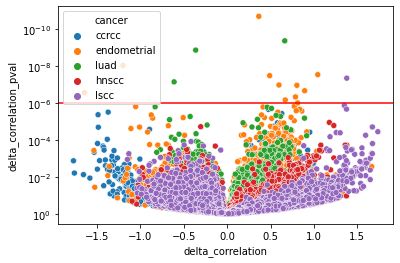

In [25]:
g = sns.scatterplot(data = correlation_df, x = 'delta_correlation', y = 'delta_correlation_pval', hue = 'cancer')
g.invert_yaxis()
g.set_yscale('log')
#for x,y,z in zip(sig_correlation_change_df['delta_correlation'], sig_correlation_change_df['delta_correlation_pval'], sig_correlation_change_df['gene']):
 #   plt.text(x = x, y = y * .9, s = z, color = 'black', rotation = 45)
plt.axhline(y = 0.05 / len(correlation_df), color = 'r')


In [14]:
sig_omics_df = omics_df[omics_df.gene.isin(sig_correlation_change_df.gene)]

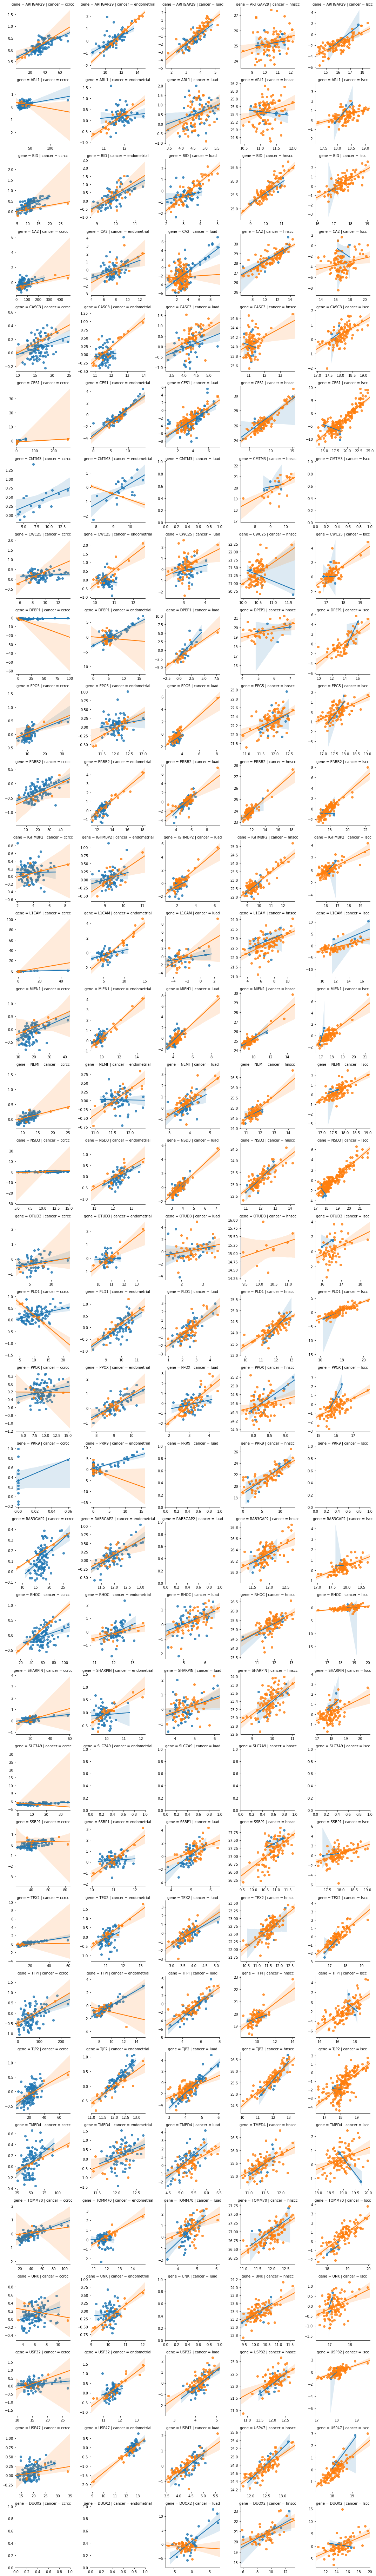

In [17]:
g = sns.FacetGrid(data = sig_omics_df, col = 'cancer',row = 'gene', hue = 'mutation_status', sharex = False, sharey = False)
g.map_dataframe(sns.regplot, x = 'transcriptomics', y = 'proteomics', fit_reg = True, truncate = False)

In [19]:
df1 = sig_correlation_change_df.melt(value_vars = ['non_mutated_correlation', 'mutated_correlation'], var_name = 'mutation_status', value_name = 'correlation', id_vars = ['gene', 'cancer']).replace(['non_mutated_correlation', 'mutated_correlation'], ['wt', 'mutated'])
df2 = sig_correlation_change_df.melt(value_vars = ['mutated_p_vals', 'non_mutated_p_vals'], value_name = 'p-val',var_name = 'mutation_status', id_vars = ['gene', 'cancer']).replace(['mutated_p_vals', 'non_mutated_p_vals'], ['mutated', 'wt'])
df = pd.merge(df1, df2)
significant_correlations = []
for index, row in df.iterrows():
    cancer = row['cancer']
    sig_corr = row['p-val'] = 0.05 / sum(correlation_df.cancer == cancer)
    significant_correlations.append(sig_corr)
df['significant_correlation'] = sig_corr

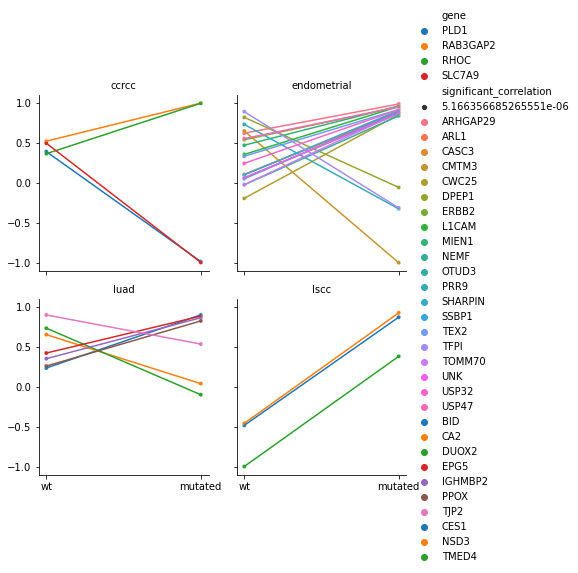

In [24]:
g = sns.FacetGrid(data = df, col = 'cancer', col_wrap = 2)
g.map_dataframe(sns.lineplot, x = 'mutation_status', y = 'correlation', hue = 'gene', legend = False)
g.map_dataframe(sns.scatterplot, x = 'mutation_status', y = 'correlation', hue = 'gene', size = 'significant_correlation')
#ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
g.set_titles('{col_name}')
g.add_legend()
#plt.title('TP53 Mutation Effects')